# ЗАДАЧА
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

## ВАМ НЕОБХОДИМО:
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

## ОПИСАНИЕ ДАННЫХ
Для выполнения задания вам необходимы файлы train.csv, lectures.csv, questions.csv.

**TRAIN.CSV**
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.
 

**QUESTIONS.CSV**: METADATA FOR THE QUESTIONS POSED TO USERS.
- question_id: foreign key for the train/test content_id column, when the content type is question (0).
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.
 

**LECTURES.CSV**: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.
- lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
- part: top level category code for the lecture.
- tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- type_of: brief description of the core purpose of the lecture.

In [1]:
# Для выполнения работы импортируем необходимые библиотеки
import pandas as pd
import numpy as np

In [2]:
# Прочитаем csv файлы
df_t = pd.read_csv('train.csv', sep=',')
df_q = pd.read_csv('questions.csv', sep=',')
df_l = pd.read_csv('lectures.csv', sep=',')
display(df_t)
display(df_q)
display(df_l)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Выведем информацию о каждом датафрейме

In [3]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [4]:
df_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [5]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


## 1. Рассмотрим **train**

In [10]:
# Посмотрим сколько занимает памяти каждый столбец
df_t.memory_usage()

Index                             809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

Датафрейм train довольно большой (101230332 строк, 9 столбцов) и занимает много места, поэтому будет лучше, если выполнить преобразование типов (как в описании)

In [6]:
df_t = pd.read_csv('train.csv', sep=',', index_col=0,
                       dtype = {'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 
                                'content_type_id': 'int8', 'task_container_id': 'int16', 'user_answer': 'int8', 
                                'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                                'prior_question_had_explanation': 'boolean'
                               }
                      )

display(df_t)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...
101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True


In [7]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.1 GB


Благодаря преобразованию типов, получилось сократить используемую память train с 7.5+ Гб до 3.1 Гб

In [16]:
# Посмотрим, как изменились значения для каждого столбца
df_t.memory_usage()

Index                             809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

Покажем, какое количество уникальных значений в каждом столбце

In [30]:
unique_list = []
for col in df_t.columns:
    item = (col, df_t[col].nunique(), df_t[col].dtype)
    unique_list.append(item)
unique_counts = pd.DataFrame(unique_list,
                             columns=['Column_Name', 'Num_Unique', 'Type']
                            ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts)

,Column_Name,Num_Unique,Type
0,content_type_id,2,int8
1,prior_question_had_explanation,2,boolean
2,answered_correctly,3,int8
3,user_answer,5,int8
4,prior_question_elapsed_time,3258,float32
5,task_container_id,10000,int16
6,content_id,13782,int16
7,user_id,393656,int32
8,timestamp,72821015,int64


In [19]:
print('Всего', df_t['user_id'].nunique(), 'пользователей')

Всего 393656 пользователей


In [36]:
content = df_t['content_type_id'].value_counts(normalize=True) * 100
print(f'Из всех записей {round(content[0], 2)}% - это ответы на вопросы, а {round(content[1], 2)}% - просмотры лекций')

Из всех записей 98.06% - это ответы на вопросы, а 1.94% - просмотры лекций


In [38]:
# "-1" исключаем, т.к. никакого ответа от просмотра лекции не следует
answer = df_t[df_t['answered_correctly'] != -1]['answered_correctly'].value_counts(normalize=True) * 100
print(f'Правильных ответов на вопросы - {round(answer[1], 2)}%; неправильных - {round(answer[0], 2)}%')

Правильных ответов на вопросы - 65.72%; неправильных - 34.28%


In [40]:
print(df_t['task_container_id'].nunique(), 'уникальных блоков вопросов или лекций')

10000 уникальных блоков вопросов или лекций


In [52]:
user_percent = df_t[df_t['answered_correctly'] != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Наибольшее количество вопросов, на которые ответил пользователь - {user_percent["Answers"].max()}')

Наибольшее количество вопросов, на которые ответил пользователь - 17609


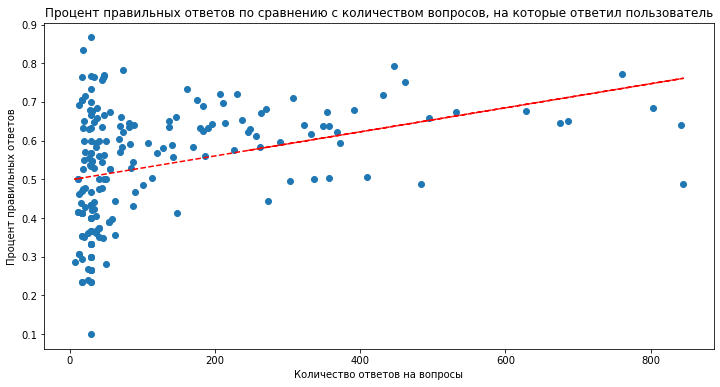

In [65]:
import matplotlib.pyplot as plt

user_percent = user_percent.query('Answers <= 10000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent['Answers']
y = user_percent['Mean']
plt.scatter(x, y, marker='o')
plt.title("Процент правильных ответов по сравнению с количеством вопросов, на которые ответил пользователь")
plt.xticks(rotation=0)
plt.xlabel("Количество ответов на вопросы")
plt.ylabel("Процент правильных ответов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

Можно отметить, что наблюдается некая зависимость того, что, чем больше студенты отвечают на вопросы, тем выше в среднем становится процент правильных ответов

In [58]:
wrong = df_t[df_t['answered_correctly'] == 0]['prior_question_had_explanation'].value_counts(normalize=True) * 100
right = df_t[df_t['answered_correctly'] == 1]['prior_question_had_explanation'].value_counts(normalize=True) * 100

print(f'При неправильном ответе {round(wrong[1], 2)}% видели ответ на предыдущий вопрос, {round(wrong[0], 2)}% - не видели')
print(f'При правильном ответе {round(right[1], 2)}% видели ответ на предыдущий вопрос, {round(right[0], 2)}% - не видели')

При неправильном ответе 86.46% видели ответ на предыдущий вопрос, 13.54% - не видели
При правильном ответе 92.92% видели ответ на предыдущий вопрос, 7.08% - не видели


Теперь стоит отметить, что пользователи, которые "верно" отвечают на вопросы, чаще видят ответы на предыдущие вопросы

In [49]:
df_t[df_t['content_type_id'] == 0]['timestamp'].mean()/1000/60/60
df_t[df_t['content_type_id'] == 1]['timestamp'].mean()/1000/60/60

2162.218120029115

## 2. Рассмотрим **questions**

In [88]:
# Перезапишем с указанными в задании типами
df_q = pd.read_csv('questions.csv', sep=',',
                        dtype = {'question_id': 'int16', 'bundle_id': 'int16', 'correct_answer': 'int8',
                                 'part': 'int8', 'tags': 'object'
                               })
df_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int16 
 1   bundle_id       13523 non-null  int16 
 2   correct_answer  13523 non-null  int8  
 3   part            13523 non-null  int8  
 4   tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memory usage: 185.0+ KB


In [89]:
df_q

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [90]:
len(df_q[df_q['question_id'] == df_q['bundle_id']])

9765

Гипотеза о том, что значения 'question_id' and 'bundle_id' во всех строках равны отвергнута

Покажем, какое количество уникальных значений в каждом столбце

In [92]:
unique_list_q = []
for col in df_q.columns:
    item = (col, df_q[col].nunique(), df_q[col].dtype)
    unique_list_q.append(item)
unique_counts_q = pd.DataFrame(unique_list_q,
                               columns=['Column_Name', 'Num_Unique', 'Type']
                              ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_q)

,Column_Name,Num_Unique,Type
0,correct_answer,4,int8
1,part,7,int8
2,tags,1519,object
3,bundle_id,9765,int16
4,question_id,13523,int16


In [76]:
df_q['correct_answer'].value_counts()

0    3716
3    3544
1    3478
2    2785
Name: correct_answer, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7')])

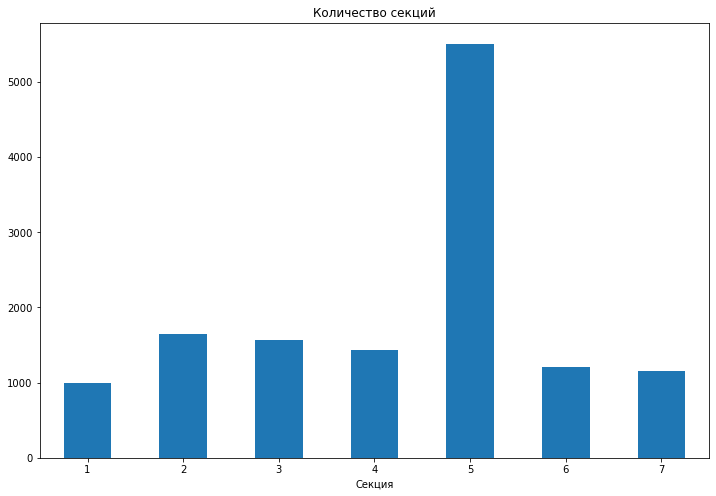

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = df_q.groupby("part").count()['question_id'].plot.bar()
plt.title("Количество секций")
plt.xlabel("Секция")
plt.xticks(rotation=0)

In [86]:
df_q['tags'].describe()

count     13522
unique     1519
top           8
freq        738
Name: tags, dtype: object

## 3. Рассмотрим **lectures**

In [87]:
# Перезапишем с указанными в задании типами
df_l = pd.read_csv('lectures.csv', sep=',',
                      dtype = {'lecture_id': 'int16', 'tag': 'int16', 
                               'part': 'int8', 'type_of': 'object'})
df_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int16 
 1   tag         418 non-null    int16 
 2   part        418 non-null    int8  
 3   type_of     418 non-null    object
dtypes: int16(2), int8(1), object(1)
memory usage: 5.4+ KB


Покажем, какое количество уникальных значений в каждом столбце

In [93]:
unique_list_lec = []
for col in df_l.columns:
    item = (col, df_l[col].nunique(), df_l[col].dtype)
    unique_list_lec.append(item)
unique_counts_lec = pd.DataFrame(unique_list_lec,
                                 columns=['Column_Name', 'Num_Unique', 'Type']
                                ).sort_values(by='Num_Unique',  ignore_index=True)
display(unique_counts_lec)

,Column_Name,Num_Unique,Type
0,type_of,4,object
1,part,7,int8
2,tag,151,int16
3,lecture_id,418,int16


In [95]:
df_l['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

Видно, что на тему 5 проводилось больше всего лекций

In [96]:
df_l['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

Очевидно, что почти все лекции были типа 'concept' и 'solving question'